# Load Libraries

In [26]:
# Install RPostgres if needed:
#install.packages("RPostgres")
#install.packages("tidyverse")

In [1]:
library(DBI)
library(ggplot2)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [51]:
mytheme <- function() {
  return(theme_minimal() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              # panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
            #  axis.ticks = element_line(size=0.05),
            #  axis.ticks.length=unit("-0.05", "in"),
            #  axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(family = "Times", size=5),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
            #  legend.title = element_blank(),
            #  legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=4, height=3, units=c("in"))
}


# Connect to DB, load data, clean data

In [3]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [4]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
unique_deps_across_versions <- dbGetQuery(con, "
    SELECT *
    FROM analysis.unique_deps_yearly_latest --unique_deps_yearly_latest_depended_on_only, unique_deps_yearly_latest
")

In [5]:
unique_deps_across_versions$dep_type <- sapply(unique_deps_across_versions$dep_type, as.character)
unique_deps_across_versions$dep_typeFact <- as.factor(unique_deps_across_versions$dep_type)
unique_deps_across_versions$composite_constraint_type <- sapply(unique_deps_across_versions$composite_constraint_type, as.character)
unique_deps_across_versions$composite_constraint_typeFact <- as.factor(unique_deps_across_versions$composite_constraint_type)

In [6]:
unique_deps_across_versions$composite_constraint_typeFact <- fct_collapse(unique_deps_across_versions$composite_constraint_typeFact,
    "Minor (^1.2.3)"="range-minor",
    "Exact (=1.2.3)"="range-=",
    "Bug (~1.2.3)"="range-patch",
    "Any (*)"="range-major",
    "Geq (>=1.2.3)"="range->=",
    # Tag="tag",
    other_level="Other"
)

In [7]:
unique_deps_across_versions$composite_constraint_typeFact <- factor(
    unique_deps_across_versions$composite_constraint_typeFact, levels=c("Exact (=1.2.3)", "Bug (~1.2.3)", "Minor (^1.2.3)", "Geq (>=1.2.3)", "Any (*)", "Other"))

In [8]:
head(unique_deps_across_versions)

,package_id,year,dependency_id,dep_type,composite_constraint_type,dep_typeFact,composite_constraint_typeFact
,<int64>,<dbl>,<int64>,<chr>,<chr>,<fct>,<fct>
1,623262,2020,774867,prod,range-minor,prod,Minor (^1.2.3)
2,695422,2020,106147,prod,range-minor,prod,Minor (^1.2.3)
3,2437459,2021,479634,prod,range-minor,prod,Minor (^1.2.3)
4,2096802,2016,3486,prod,range-minor,prod,Minor (^1.2.3)
5,50806,2017,39411,prod,range-minor,prod,Minor (^1.2.3)
6,2532533,2022,22027238,prod,range-minor,prod,Minor (^1.2.3)


In [9]:
year_sums <- unique_deps_across_versions %>% 
    group_by(year) %>% 
    summarise(year_total=n())

In [10]:
# Get the percentage of each composite_constraint_typeFact within each year



dep_by_year_percs <- unique_deps_across_versions %>% 
    group_by(year, composite_constraint_typeFact) %>% 
    summarise(count=n()) %>% 
    inner_join(year_sums, by="year") %>%
    mutate(percentage = count / year_total)
    # mutate(percentage = count / sum(count)) 
    # %>% 
    # ggplot(aes(x=yearFact, y=percentage, fill=composite_constraint_typeFact)) +
    #     geom_bar(stat="identity") +
    #     theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    #     labs(x="Year", y="Percentage of Dependencies", fill="Constraint Type") +
    #     scale_fill_brewer(palette="Set1") +
    #     theme(legend.position="bottom")

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


In [11]:
head(dep_by_year_percs)

year,composite_constraint_typeFact,count,year_total,percentage
<dbl>,<fct>,<int>,<int>,<dbl>
2010,Exact (=1.2.3),19,134,0.14179104
2010,Geq (>=1.2.3),105,134,0.78358209
2010,Any (*),4,134,0.02985075
2010,Other,6,134,0.04477612
2011,Exact (=1.2.3),1999,9615,0.20790432
2011,Bug (~1.2.3),2115,9615,0.21996880


In [12]:
dep_by_year_percs$yearFact <- factor(dep_by_year_percs$year)

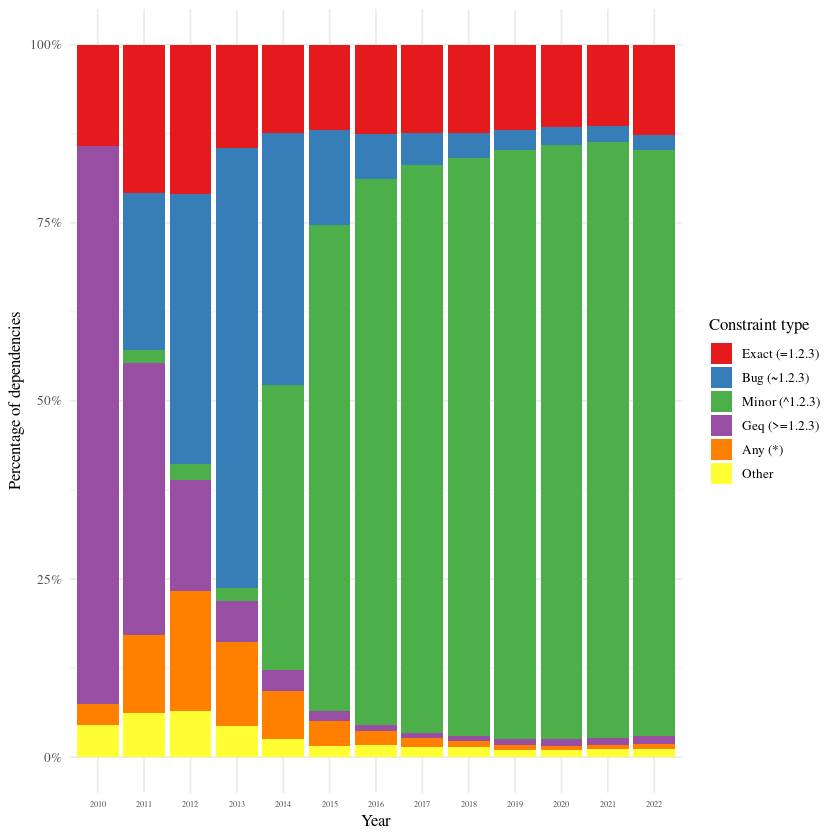

In [52]:
# plot a stacked area plot of composite_constraint_typeFact over year
ggplot(dep_by_year_percs, aes(x=yearFact, y=percentage, fill=composite_constraint_typeFact)) +
    geom_col() +
    scale_x_discrete() +
    scale_fill_brewer(palette="Set1") +
    scale_y_continuous(labels = scales::percent) + 
    # theme_minimal() +
    # theme(legend.position="bottom") +
    labs(x="Year", y="Percentage of dependencies", fill="Constraint type") +
    mytheme()

mysave("plots/rq1/constraint_usage_over_time.pdf")